In [1]:
# %load ../load_magic/storage.py

!mkdir ../data
!mkdir ../data/csv
!mkdir ../saves
!mkdir ../saves/pickle
!mkdir ../saves/csv
import pickle
import pandas as pd
import os

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][2]

# Change this to your data and saves folders
data_folder = r'../data/'
saves_folder = r'../saves/'

def load_csv(csv_name=None):
    csv_folder = data_folder + 'csv/'
    if csv_name is None:
        csv_path = max([os.path.join(csv_folder, f) for f in os.listdir(csv_folder)],
                       key=os.path.getmtime)
    else:
        csv_path = csv_folder + csv_name + '.csv'
    data_frame = pd.read_csv(csv_path, encoding=encoding)
    
    return(data_frame)

def load_object(obj_name):
    pickle_path = saves_folder + 'pickle/' + obj_name + '.pickle'
    try:
        object = pd.read_pickle(pickle_path)
    except:
        with open(pickle_path, 'rb') as handle:
            object = pickle.load(handle)
    
    return(object)

def save_dataframes(include_index=False, **kwargs):
    csv_folder = saves_folder + 'csv/'
    for frame_name in kwargs:
        if isinstance(kwargs[frame_name], pd.DataFrame):
            csv_path = csv_folder + frame_name + '.csv'
            kwargs[frame_name].to_csv(csv_path, sep=',', encoding=encoding,
                                      index=include_index)

# Classes, functions, and methods cannot be pickled
def store_objects(**kwargs):
    for obj_name in kwargs:
        if hasattr(kwargs[obj_name], '__call__'):
            raise RuntimeError('Functions cannot be pickled.')
        obj_path = saves_folder + 'pickle/' + str(obj_name)
        pickle_path = obj_path + '.pickle'
        if isinstance(kwargs[obj_name], pd.DataFrame):
            kwargs[obj_name].to_pickle(pickle_path)
        else:
            with open(pickle_path, 'wb') as handle:
                pickle.dump(kwargs[obj_name], handle, pickle.HIGHEST_PROTOCOL)

mkdir: ../data: File exists
mkdir: ../data/csv: File exists
mkdir: ../saves: File exists
mkdir: ../saves/pickle: File exists
mkdir: ../saves/csv: File exists


In [113]:

# Download CoinBase prices
from urllib.request import urlretrieve
from gzip import GzipFile
import os

# http://api.bitcoincharts.com/v1/csv/
out_file_path = data_folder + 'csv/coinbaseUSD.csv'
if not os.path.isfile(out_file_path):
    price_history_url = 'http://api.bitcoincharts.com/v1/csv/coinbaseUSD.csv.gz'
    local_filename, headers = urlretrieve(price_history_url)
    with gzip.open(local_filename, 'rb') as f:
        price_history_decompressed = f.read()
    with open(out_file_path, 'w') as output:
        size = output.write(price_history_decompressed.decode())

In [121]:

price_history_df = pd.read_csv(out_file_path, encoding=encoding, header=None)

In [122]:

import numpy as np

price_history_df.columns = ['time_stamp', 'price', 'idono']
price_history_df['date'] = price_history_df['time_stamp'].map(lambda x: pd.to_datetime(x, unit='s'))
price_history_df['year'] = price_history_df['date'].map(lambda x: x.year)
price_history_df['month'] = price_history_df['date'].map(lambda x: x.month)
price_history_df['day'] = price_history_df['date'].map(lambda x: x.day)
price_history_df['week_day'] = price_history_df['date'].map(lambda x: x.weekday())
price_history_df['log_price'] = price_history_df['price'].map(lambda x: np.log(x))

In [123]:

# Validates with https://en.wikipedia.org/wiki/History_of_bitcoin
price_history_df.head()

,time_stamp,price,idono,date
0,1417412036,300.0,0.010000,2014-12-01 05:33:56
1,1417412423,300.0,0.010000,2014-12-01 05:40:23
2,1417415048,370.0,0.010000,2014-12-01 06:24:08
3,1417416612,370.0,0.026556,2014-12-01 06:50:12
4,1417498166,377.0,0.010000,2014-12-02 05:29:26


In [124]:

price_history_df.loc[price_history_df.shape[0]-1]

time_stamp             1512614121
price                     13968.7
idono                    0.158102
date          2017-12-07 02:35:21
Name: 26285810, dtype: object


## Buying Digital Currency

Fees are added to the amount entered to arrive at the total for the order. For example, if you enter \$100 USD as the amount of BTC to buy, and the fee is 1.49%, your total will be \$101.49. That total will be charged to your payment method and you will receive \$100 worth of BTC.

In [126]:

match_series = (price_history_df['log_price'] <= 0)
price_history_df = price_history_df[~match_series]

In [127]:

store_objects(price_history_df=price_history_df)

In [128]:

groupby_list = ['year', 'month', 'day']
monday_price_df = price_history_df.groupby(groupby_list,
                                           as_index=False).apply(lambda x: x.loc[[x.date.idxmax()]]).copy()
match_series = (monday_price_df['week_day'] == 0)
monday_price_df = monday_price_df[match_series].reset_index(drop=True)

In [129]:

from datetime import datetime
import pandas as pd

trading_fee = 0.0149
weekly_budget = 5.0
latest_price = price_history_df.loc[price_history_df.shape[0]-1]['price']
def total_saved(weekly_budget, format_result=True):
    weekly_amount = weekly_budget - weekly_budget*trading_fee
    column_list = ['date_time', 'shares_added']
    rows_list = []
    trading_date = datetime(monday_price_df.loc[0, 'year'].squeeze(),
                            monday_price_df.loc[0, 'month'].squeeze(),
                            monday_price_df.loc[0, 'day'].squeeze())
    for row_index, row_series in monday_price_df.iterrows():
        row_dict = {}
        row_dict['date_time'] = row_series['date']
        row_dict['shares_added'] = weekly_amount/row_series['price']
        rows_list.append(row_dict)

    weekly_amount_df = pd.DataFrame(rows_list, columns=column_list)
    total_amount = weekly_amount_df['shares_added'].sum()*latest_price
    if format_result:
        total_amount = '${:,.2f}'.format(total_amount)
    
    return total_amount

In [130]:

print(total_saved(10.))

$43,661.15


In [131]:

import statsmodels.formula.api as smf

# Use ols function for calculating the F-statistic and associated p value
price_history_ols = smf.ols(formula='log_price ~ time_stamp', data=price_history_df)
price_history_fitted = price_history_ols.fit()
price_history_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 2.443e+08
Date:                Thu, 07 Dec 2017   Prob (F-statistic):               0.00
Time:                        14:10:55   Log-Likelihood:            -1.1949e+07
No. Observations:            26285809   AIC:                         2.390e+07
Df Residuals:                26285807   BIC:                         2.390e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -55.1951      0.004  -1.38e+04      0.000     -55.203     -55.187
time_stamp  4.214e-08    2.7e-12   1.56e+04      0.000    4.21e-08    4.21e-08
==============================================================================
Omnibus:                  1145503.607   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           720583.634
Skew:                           0.277   Prob(JB):                         0.00
Kurtosis:                       2.407   Cond. No.                     7.93e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.93e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [132]:

params_series = price_history_fitted.params

def date_when(amount):
    time_stamp = (np.log(amount)-params_series.loc['Intercept'])/params_series.loc['time_stamp']
    date_time = pd.to_datetime(time_stamp, unit='s')
    
    return date_time.strftime('%Y-%m-%d')

In [135]:

date_when(10000)

'2018-06-06'

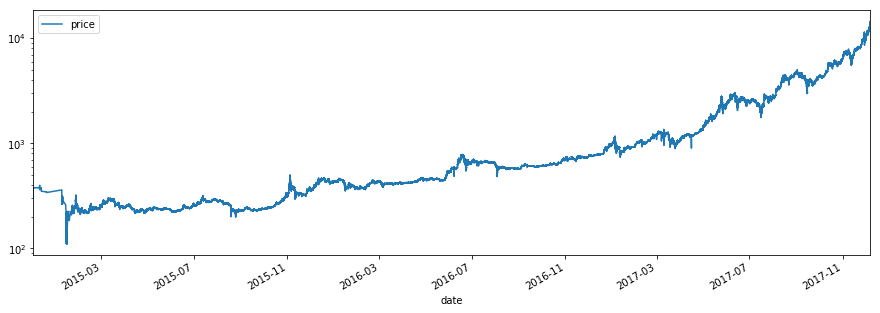

In [136]:

%matplotlib inline

axes_sub_plot = price_history_df.plot(x='date', y='price', kind='line', figsize=(15, 5), logy=True)

In [142]:

axes_sub_plot.plot(x=price_history_df['date'], y=np.exp(params_series.loc['Intercept']+price_history_df['log_price']*params_series.loc['time_stamp']),
                   kind='line', figsize=(15, 5), logy=True)

[]

In [144]:

price_history_df.loc[0, 'date']

Timestamp('2014-12-01 05:33:56')

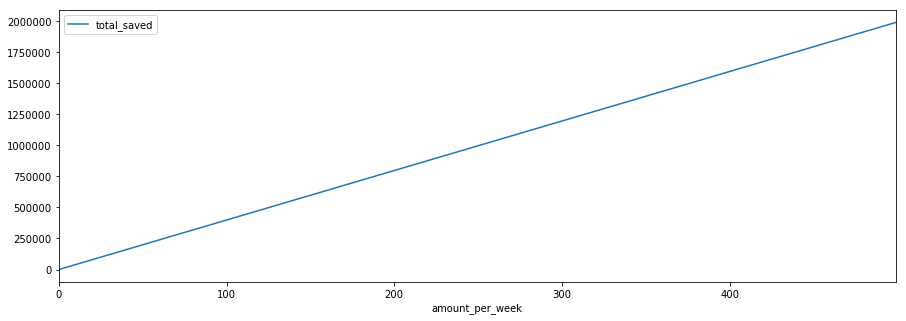

In [82]:

column_list = ['amount_per_week', 'total_saved']
amount_per_week = range(0, 500)
amount_saved = [total_saved(amount, format_result=False) for amount in amount_per_week]
rows_list = [dict(zip(column_list, [w, s])) for w, s in zip(amount_per_week, amount_saved)]
weekly_amount_df = pd.DataFrame(rows_list, columns=column_list)
axes_sub_plot = weekly_amount_df.plot(x='amount_per_week', y='total_saved', kind='line', figsize=(15, 5), logy=False)

In [147]:

WMT_df = load_csv('WMTHistoricalQuotes')
WMT_df['log_open'] = WMT_df['open'].map(lambda x: np.log(x))
WMT_df['date'] = WMT_df['date'].map(lambda x: pd.to_datetime(x.strip()))
WMT_df.head()

,date,close,volume,open,high,low,log_open
0,2017-12-07 16:00:00,96.78,"7,495,476",97.09,97.58,96.6500,4.575638
1,2017-12-07 00:00:00,96.78,7498316.0000,97.06,97.58,96.6500,4.575329
2,2017-12-06 00:00:00,97.28,7138716.0000,97.99,98.14,97.2401,4.584865
3,2017-12-05 00:00:00,97.83,9009041.0000,97.00,97.94,96.9200,4.574711
4,2017-12-04 00:00:00,97.01,8954996.0000,97.73,97.96,96.6750,4.582209


In [143]:

price_history_df['log_price'].std()

1.2231262872455024

In [151]:

match_series = (WMT_df['date'] < price_history_df.loc[0, 'date'])
WMT_df[~match_series]['log_open'].std()

0.11093116067293594

In [152]:

price_history_df.shape

(26285809, 9)

In [167]:

SaP_df = pd.read_html(data_folder + 'html/S_and_P_500_by_month.html')[0]
SaP_df.columns = ['date', 'price']
SaP_df = SaP_df.reindex(SaP_df.index.drop(0))
SaP_df['date'] = SaP_df['date'].map(lambda x: pd.to_datetime(x.strip()))
match_series = (SaP_df['date'] < price_history_df.loc[0, 'date'])
SaP_df = SaP_df[~match_series]
SaP_df['price'] = SaP_df['price'].map(lambda x: float(x))
SaP_df['log_price'] = SaP_df['price'].map(lambda x: np.log(x))
SaP_df.tail()

,date,price,log_price
31,2015-05-01,2111.94,7.655362
32,2015-04-01,2094.86,7.647242
33,2015-03-01,2079.99,7.640118
34,2015-02-01,2082.20,7.641180
35,2015-01-01,2028.18,7.614894


In [168]:

SaP_df['log_price'].std()

0.08153343733940152